Import dependencies

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Initializing constants

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 100

Loading dataset

In [6]:
dataset_name = "facades"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent / dataset_name


Loading the images

In [7]:
def load(image_file):
    image = load_img(image_file)
    image = img_to_array(image)
    w = image.shape[1] // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    return input_image, real_image

# Pre-Processing

In [8]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width])
    real_image = tf.image.resize(real_image, [height, width])
    return input_image, real_image

In [9]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

Training Images

In [10]:
def load_image_train(image_file):
    input_image, real_image = load(image_file.numpy().decode())
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

Testing Images

In [11]:
def load_image_test(image_file):
    input_image, real_image = load(image_file.numpy().decode())
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

Dataset

In [12]:
def create_dataset(path, train=True):
    images = list(map(str, path.glob('*.jpg')))
    dataset = tf.data.Dataset.from_tensor_slices(images)
    if train:
        dataset = dataset.map(lambda x: tf.py_function(load_image_train, [x], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(BUFFER_SIZE)
        dataset = dataset.batch(BATCH_SIZE)
    else:
        dataset = dataset.map(lambda x: tf.py_function(load_image_test, [x], [tf.float32, tf.float32]))
        dataset = dataset.batch(BATCH_SIZE)
    return dataset

Creating dataset

In [13]:
train_dataset = create_dataset(PATH / 'train')
test_dataset = create_dataset(PATH / 'test', train=False)

**Generator**

In [14]:
def build_generator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))
        if apply_batchnorm:
            result.add(BatchNormalization())
        result.add(LeakyReLU())
        return result

**Upsampling for descriminator**

In [21]:
def build_generator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))
        if apply_batchnorm:
            result.add(BatchNormalization())
        result.add(LeakyReLU())
        return result

    def upsample(filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(Conv2DTranspose(filters, size, strides=2,
                                   padding='same',
                                   kernel_initializer=initializer,
                                   use_bias=False))
        result.add(BatchNormalization())
        if apply_dropout:
            result.add(Dropout(0.5))
        result.add(ReLU())
        return result

    inputs = Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)



**Discriminator**

In [22]:
def build_discriminator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)
        result = tf.keras.Sequential()
        result.add(Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))
        if apply_batchnorm:
            result.add(BatchNormalization())
        result.add(LeakyReLU())
        return result

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')

    x = Concatenate()([inp, tar])

    down1 = downsample(64, 4, apply_batchnorm=False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(512, 4, strides=1,
                  kernel_initializer=initializer,
                  use_bias=False)(zero_pad1)

    batchnorm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    last = Conv2D(1, 4, strides=1,
                  kernel_initializer=initializer)(zero_pad2)

    return Model(inputs=[inp, tar], outputs=last)


Using cross-entropy loss function

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator Loss function

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

Generator Loss function

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

Optimizing generator and discriminator

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Training step

In [27]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

Image generation

In [28]:
def generate_images(model, test_input, tar, epoch):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to display properly
        plt.imshow((display_list[i] + 1) / 2)
        plt.axis('off')
    plt.savefig(f'output_{epoch}.png')  # Save the image
    plt.show()

Training the models

In [29]:
def fit(train_ds, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for input_image, target in train_ds:
            gen_loss, disc_loss = train_step(input_image, target, epoch)

        # Generate and save images at the end of each epoch
        for input_image, target in test_dataset:
            generate_images(generator, input_image, target, epoch)
            break  # Generate images only for the first batch of the test dataset

        # Print the losses at the end of each epoch
        print(f"Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

Initializing generator and discriminator

In [30]:
generator = build_generator()
discriminator = build_discriminator()

Training

Epoch 1/5


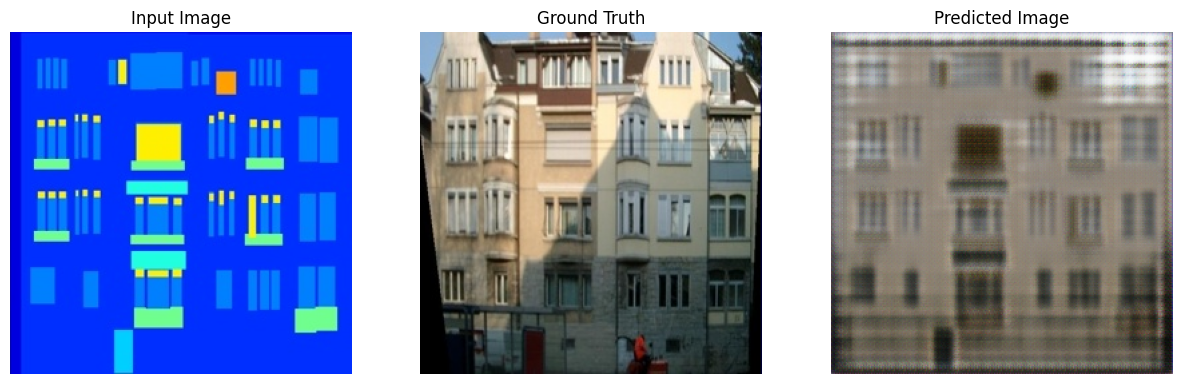

Generator Loss: 41.847415924072266, Discriminator Loss: 0.3269711136817932
Epoch 2/5


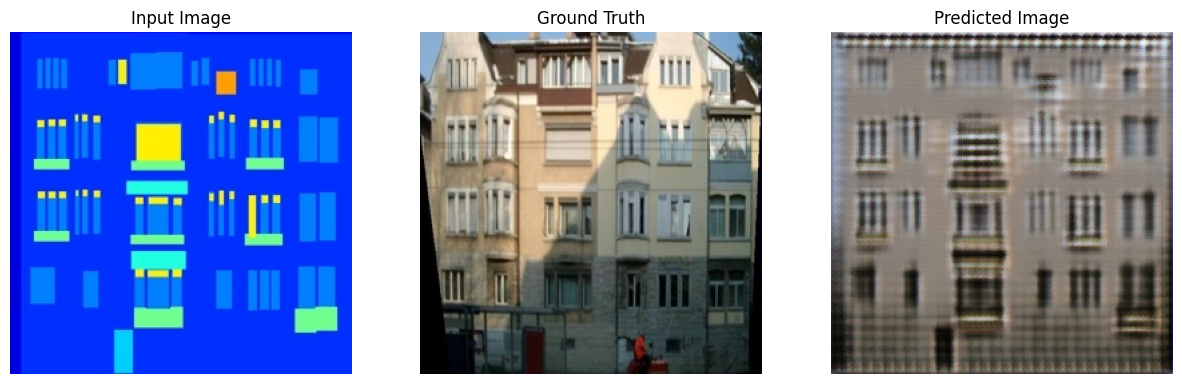

Generator Loss: 41.885704040527344, Discriminator Loss: 0.09955932199954987
Epoch 3/5


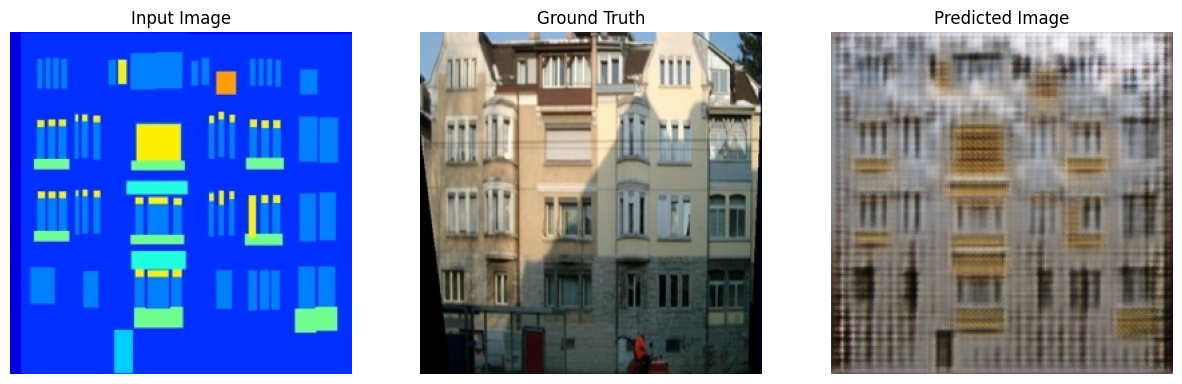

Generator Loss: 52.68834686279297, Discriminator Loss: 0.042727358639240265
Epoch 4/5


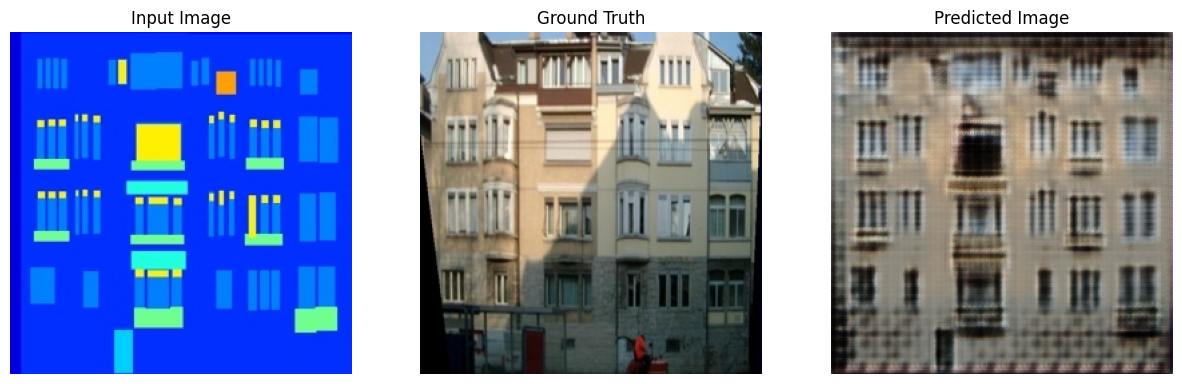

Generator Loss: 50.793575286865234, Discriminator Loss: 0.06205803155899048
Epoch 5/5


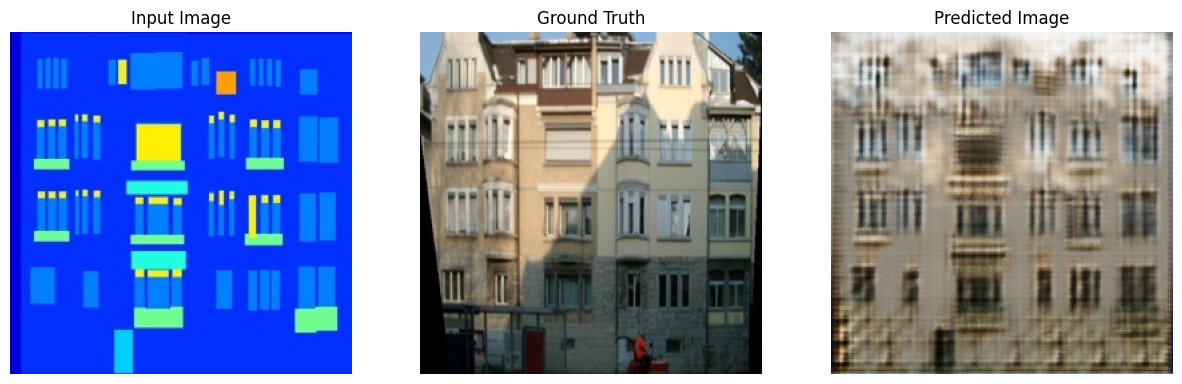

Generator Loss: 39.96244812011719, Discriminator Loss: 1.507488489151001


In [31]:
fit(train_dataset, epochs=5)